### This script analysis the utilizaton of EV chargers based on the dataset from the paper titled "# Use this to focus on a subset of charging company or Locations."
#### The data set includes 72,856 sessions from 2,337 EV users and 2,119 chargers. This dataset is stored locally in **'ChargingRecords.csv'**

#### See link for more details. https://figshare.com/articles/dataset/A_dataset_for_multi-faceted_analysis_of_electric_vehicle_charging_transactions/22495141/1


In [141]:
def plot_hist(dataframe, column_name, bins=10,title='title'):
    """
    Plots a histogram of a specified column in a pandas DataFrame.

    Parameters:
        dataframe (pd.DataFrame): The pandas DataFrame containing the data.
        column_name (str): The name of the column for which the histogram is to be plotted.
        bins (int, optional): The number of bins in the histogram. Default is 10.

    Returns:
        None
    """
    # Plot histogram of specified column
    plt.hist(dataframe[column_name], bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [142]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [143]:
df=pd.read_csv('ChargingRecords.csv')
df.head()

,UserID,ChargerID,ChargerCompany,Location,ChargerType,StartDay,StartTime,EndDay,EndTime,StartDatetime,EndDatetime,Duration,Demand
0,0,1,1,hotel,0,2022-09-15,20:54:02,2022-09-15,23:59:13,2022-09-15 20:54,2022-09-15 23:59,185,20.36
1,0,1,1,hotel,0,2022-09-14,20:01:05,2022-09-14,21:31:04,2022-09-14 20:01,2022-09-14 21:31,90,10.19
2,0,1,1,hotel,0,2022-09-14,18:54:30,2022-09-14,19:54:29,2022-09-14 18:54,2022-09-14 19:54,60,6.78
3,0,1,1,hotel,0,2022-09-29,18:32:51,2022-09-30,0:16:42,2022-09-29 18:32,2022-09-30 0:16,344,37.65
4,0,1,1,hotel,0,2022-09-25,19:30:15,2022-09-26,0:30:14,2022-09-25 19:30,2022-09-26 0:30,300,33.81


In [144]:
df.ChargerCompany.unique()

array([1, 0])

#### We will first focus on fast chargers  (ChargerType=1) and then repeat the same analysis for slow chargers (ChargerType=0). To that end, first filter the dataframe to fast chargers only. 

In [145]:
print(f'Total number of sessions: {len(df)}')
#df=df.loc[df['ChargerType']==1] # If you want slow chargers, set ChargerType==0. If you want all chargers, just comment out this line. 
print(f'Total number of Fast Charger sessions : {len(df)}')

Total number of sessions: 72856
Total number of Fast Charger sessions : 72856


#### Next we aggregate charging sessions data to a **daily level** and calculate daily utlization.
#### Note that calculation of daily utilization is a **time based**. This means that we divide the charging Duration in minutes by total minutes in a day (1440 mins) to caluclate Utilization. 

#### <span style='color:red'> The challenge with Time based Utilization is that the session times can vary signifcantly by charger type (fast or slow) or location. This can bias the Utilization values. We need to figure out a way to normalize duration values to address this. This is not included in the script.</span>


In [146]:
x=df.groupby(['ChargerID', 'ChargerCompany', 'Location', 'ChargerType',
       'StartDay']).Duration.sum()
xframe=x.to_frame()
xframe=xframe.reset_index()
xframe['Duration'].astype('int')
xframe['TotalDuration']=24*60
xframe['Utilization']=xframe.Duration/xframe.TotalDuration
xframe.Utilization.describe()

count    56831.000000
mean         0.134602
std          0.127407
min         -0.020139
25%          0.034722
50%          0.100694
75%          0.187500
max          1.223611
Name: Utilization, dtype: float64

#### Next we clean out any outlier values of Utlization i.e. Days where values are >1 or <0. For sense check, first print out the number of days that meet this criteria. 

In [147]:
print(f'Number of sessions before filtering outliers: {len(xframe)}')
print(f'Number of entries with utilization >100%: {len(xframe.loc[xframe['Utilization']>1])}')
print(f'Number of entries with utilization <0%: {len(xframe.loc[xframe['Utilization']<0])}')

xframe=xframe.loc[(xframe.Utilization>=0) & (xframe.Utilization<=1)]
print(f'Number of sessions after filtering outliers: {len(xframe)}')

Number of sessions before filtering outliers: 56831
Number of entries with utilization >100%: 5
Number of entries with utilization <0%: 15
Number of sessions after filtering outliers: 56811


In [148]:
#print a snapshot of the dataframe
xframe.head()

,ChargerID,ChargerCompany,Location,ChargerType,StartDay,Duration,TotalDuration,Utilization
0,1,1,hotel,0,2021-11-04,1,1440,0.000694
1,1,1,hotel,0,2021-11-17,109,1440,0.075694
2,1,1,hotel,0,2021-11-24,2,1440,0.001389
3,1,1,hotel,0,2021-11-25,540,1440,0.375000
4,1,1,hotel,0,2021-11-29,0,1440,0.000000


#### Now we plot a histogram of EV charger Utlization across all locations and Charging Companies. 

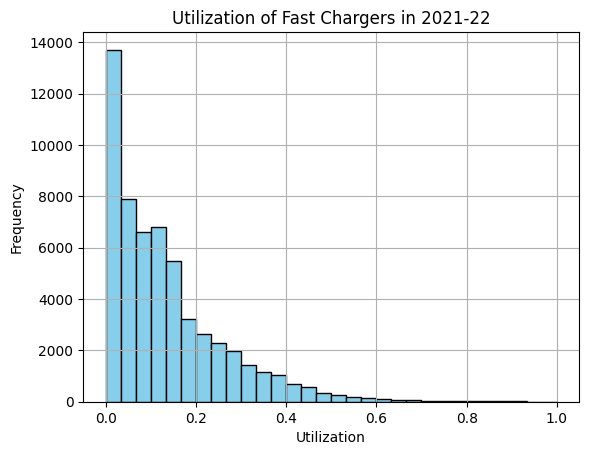

In [149]:
plot_hist(xframe,'Utilization',bins=30,title='Utilization of EV chargers in 2021-22')

#### Next we want to analyze charger Utilization by Location and Charging Company

In [150]:
#Create a new data frame and group by Location and Charging Company
result = xframe.groupby(['Location','ChargerCompany'])['Utilization'].agg(['mean', 'max', 'min'])
#type(result)
#results=result.to_frame()
result=result.reset_index()
result.columns

Index(['Location', 'ChargerCompany', 'mean', 'max', 'min'], dtype='object')

Number of unique charging companies: 2
Number of unique Location (types): 14


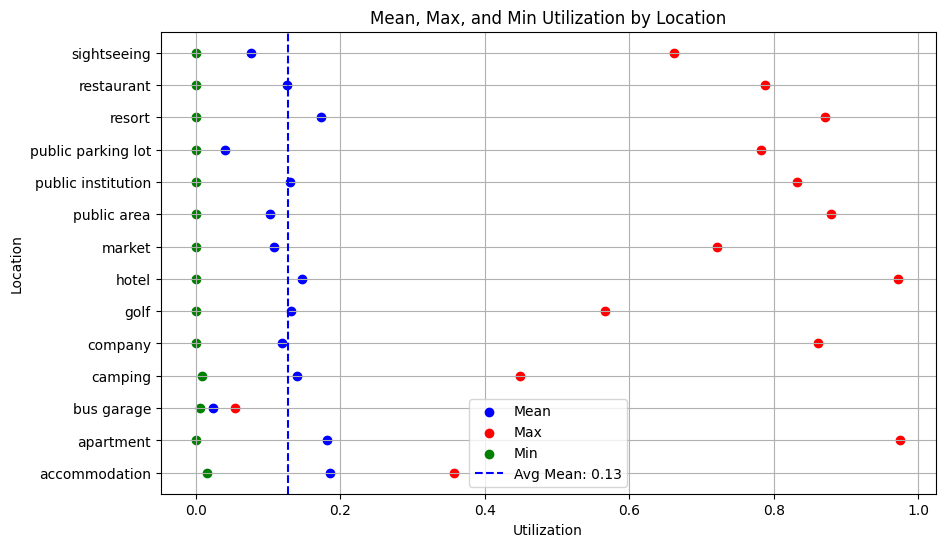

In [152]:
print(f'Number of unique charging companies: {result.ChargerCompany.nunique()}')
print(f'Number of unique Location (types): {result.Location.nunique()}')

#filtered_result = result[result['ChargerCompany'] == 1] 
# Use the above to focus on a subset of charging company or Locations. Or you can just set filtered_result=result to use all.
filtered_result=result

# Group by Location and extract mean, max, and min values
grouped_result = filtered_result.groupby('Location').agg({'mean': 'mean', 'max': 'mean', 'min': 'mean'}).reset_index()

# Plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(grouped_result['mean'], grouped_result['Location'], label='Mean', color='blue')
plt.scatter(grouped_result['max'], grouped_result['Location'], label='Max', color='red')
plt.scatter(grouped_result['min'], grouped_result['Location'], label='Min', color='green')

# Calculate the average of the mean values across locations
avg_mean = filtered_result['mean'].mean()

# Draw a vertical dotted line at the average of the mean values across locations
plt.axvline(x=avg_mean, linestyle='--', color='blue', label=f'Avg Mean: {avg_mean:.2f}')

plt.xlabel('Utilization')
plt.ylabel('Location')
plt.title('Mean, max, and min Utilization by Location')
plt.legend()
plt.grid(True)
plt.show()

#### 